# **ANÁLISIS COMPARATIVO DE LOS ÍNDICES NDSSI Y NSMI CON IMÁGENES LANDSAT-8 EN EL LAGO CHINCHAYCOCHA, JUNIN, 2023**

## Libreras 

In [1]:
# librerias basicas
import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt

#librerias de geoprosesamiento
import geopandas as gpd
import rasterio
from geopandas import GeoDataFrame
from rasterio.mask import mask
from shapely.geometry import mapping, box
from rasterio.plot import show

# librerias estadisticas
from scipy.stats import shapiro, kstest
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

## Cargar Imagenes

In [2]:
# Definir rutas
ruta_raster = r"............\Imagenes_satelitales"
ruta_shp = r"............\Laguna\Laguna.shp"

# Cambiar al directorio con los rasters y obtener la lista de TIFFs
os.chdir(ruta_raster)
lista = glob.glob("*.tif")

# Leer el shapefile
shp = gpd.read_file(ruta_shp)


## Geoprosesamiento de imagenes satelitales

In [3]:
# Inicializar un diccionario para almacenar las bandas
bandas = {}

# Iterar sobre la lista de archivos TIFF
for i, archivo in enumerate(lista):
    with rasterio.open(archivo) as src:
        if i == 0:
            # Solo necesitamos alinear el CRS una vez
            raster_crs = src.crs
            shp = shp.to_crs(raster_crs)
            geom = shp.geometry.values[0]
        
        # Enmascarar y recortar el raster usando la geometría del shapefile
        masked, transform = mask(src, [geom], crop=True)
        # Guardar la banda en el diccionario
        bandas[f'B{i+1}'] = masked

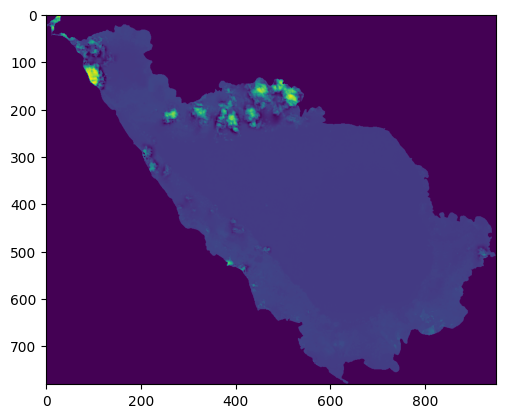

<Axes: >

In [4]:
show(bandas['B1'])

## Indices de calidad 

### Indice NDSSI

C:\Users\Anderson\AppData\Local\Temp\ipykernel_18268\2530242998.py:4: RuntimeWarning: invalid value encountered in divide
  NDSSI = (blue - nir)/(blue + nir)


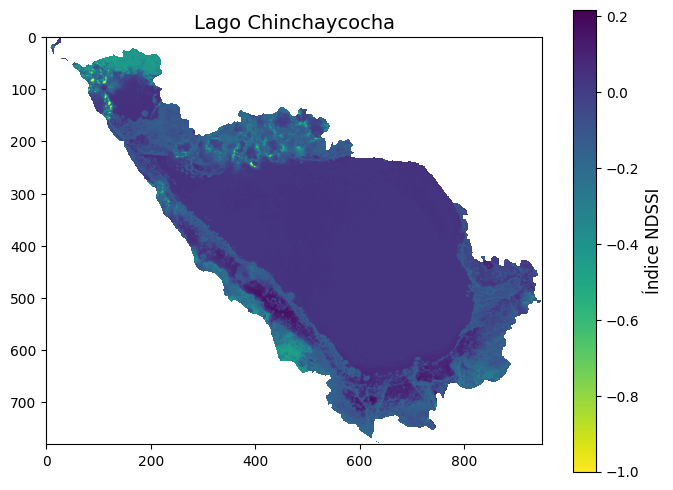

In [5]:
# Determinacion de indice
blue = bandas['B2']/bandas['B2'].max()  # Banda del blue
nir = bandas['B5']/bandas['B5'].max()   # Banda del infrarrojo cercano
NDSSI = (blue - nir)/(blue + nir)

# Mostrar el NDVI
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(NDSSI[0], cmap='viridis_r')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Índice NDSSI', fontsize=12)
ax.set_title('Lago Chinchaycocha', fontsize=14)
plt.show()

### Indice NSMI

C:\Users\Anderson\AppData\Local\Temp\ipykernel_18268\3311832987.py:5: RuntimeWarning: invalid value encountered in divide
  NSMI = (red + green - blue)/(red + green + blue)


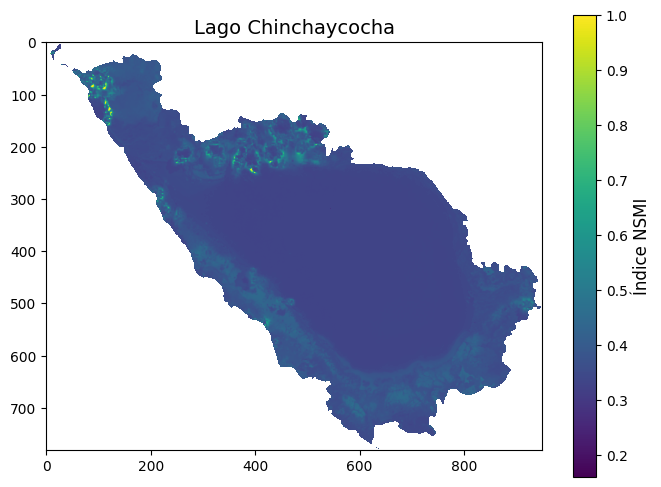

In [6]:
# Determinacion de indice
blue = bandas['B2']/bandas['B2'].max()    # Banda del azul
red = bandas['B4']/bandas['B4'].max()     # Banda del rojo
green = bandas['B3']/bandas['B3'].max()   # Banda del verde
NSMI = (red + green - blue)/(red + green + blue)

# Mostrar el NDVI
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(NSMI[0], cmap='viridis')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Índice NSMI', fontsize=12)
ax.set_title('Lago Chinchaycocha', fontsize=14)
plt.show()

## Prueba Estadistica

In [7]:
# Creacion de DataFrame
NDSSI = NDSSI[~np.isnan(NDSSI)]
NDSSI = NDSSI.tolist()
NSMI = NSMI[~np.isnan(NSMI)]
NSMI = NSMI.tolist()
datos = {'NDSSI':NDSSI, 'NSMI':NSMI}
datos = pd.DataFrame(datos)

### Normalidad

In [8]:
# Prueba de Shapiro-Wilk
print("Prueba de Shapiro-Wilk para NDSSI:")
stat, p = shapiro(datos['NDSSI'])
print(f'Estadístico={stat:.3f}, p-valor={p:.3f}')

# Prueba de Kolmogorov-Smirnov
print("\nPrueba de Kolmogorov-Smirnov para NSMI:")
stat, p = kstest(datos['NSMI'], 'norm')
print(f'Estadístico={stat:.3f}, p-valor={p:.3f}')

Prueba de Shapiro-Wilk para NDSSI:
Estadístico=0.759, p-valor=0.000

Prueba de Kolmogorov-Smirnov para NSMI:
Estadístico=0.627, p-valor=0.000


C:\Ingenieria\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 296940.
  res = hypotest_fun_out(*samples, **kwds)


### Correlación de Spearman


Coeficientes de correlación de Spearman:
NDSSI vs NSMI: -0.52019



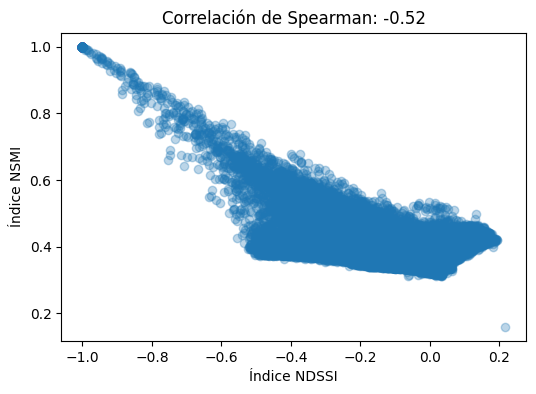

In [9]:
# Calcular la correlación de Spearman entre pares de índices
corr_coef, p_val = spearmanr(datos['NDSSI'], datos['NSMI'])
print()
print("Coeficientes de correlación de Spearman:")
print(f"NDSSI vs NSMI: {corr_coef:.5f}")
print()

# Graficar la correlación
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(datos['NDSSI'], datos['NSMI'], alpha=0.3)
ax.set_xlabel('Índice NDSSI')
ax.set_ylabel('Índice NSMI')
ax.set_title(f'Correlación de Spearman: {corr_coef:.2f}')
plt.show()


### Regresion lineal y cuadratica

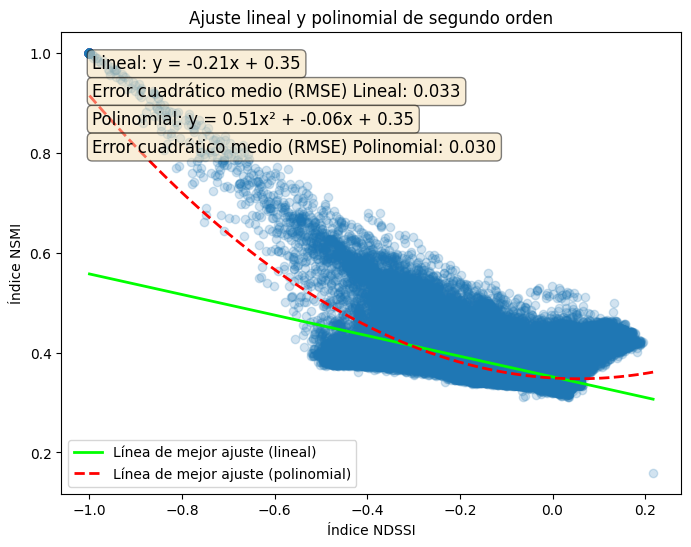

In [10]:
# Graficar la correlación
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(datos['NDSSI'], datos['NSMI'], alpha=0.2)
ax.set_xlabel('Índice NDSSI')
ax.set_ylabel('Índice NSMI')
ax.set_title(f'Ajuste lineal y polinomial de segundo orden')

# Ajuste lineal
coeffs_lineal = np.polyfit(datos['NDSSI'], datos['NSMI'], 1)
poly_lineal = np.poly1d(coeffs_lineal)
equation_lineal = f'Lineal: y = {coeffs_lineal[0]:.2f}x + {coeffs_lineal[1]:.2f}'

# Ajuste polinomial de segundo orden
coeffs_polinomio = np.polyfit(datos['NDSSI'], datos['NSMI'], 2)
poly_polinomio = np.poly1d(coeffs_polinomio)
equation_polinomio = f'Polinomial: y = {coeffs_polinomio[0]:.2f}x² + {coeffs_polinomio[1]:.2f}x + {coeffs_polinomio[2]:.2f}'

# Rango de valores para las líneas ajustadas
x_line = np.linspace(min(datos['NDSSI']), max(datos['NDSSI']), 100)

# Predicciones para las líneas ajustadas
y_line_lineal = poly_lineal(x_line)
y_line_polinomio = poly_polinomio(x_line)

# Graficar la línea de mejor ajuste lineal
ax.plot(x_line, y_line_lineal, color='lime', linestyle='-', linewidth=2, label='Línea de mejor ajuste (lineal)')

# Graficar la línea de mejor ajuste polinomial
ax.plot(x_line, y_line_polinomio, color='r', linestyle='--', linewidth=2, label='Línea de mejor ajuste (polinomial)')

# Calcular el error cuadrático medio (RMSE) para ambas líneas
y_pred_lineal = poly_lineal(datos['NDSSI'])
y_pred_polinomio = poly_polinomio(datos['NDSSI'])
mse_lineal = mean_squared_error(datos['NSMI'], y_pred_lineal)
mse_polinomio = mean_squared_error(datos['NSMI'], y_pred_polinomio)
rmse_lineal = np.sqrt(mse_lineal)
rmse_polinomio = np.sqrt(mse_polinomio)

# Agregar leyenda y ecuaciones de las líneas de mejor ajuste
ax.legend()
ax.text(0.05, 0.95, equation_lineal, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.05, 0.89, f'Error cuadrático medio (RMSE) Lineal: {rmse_lineal:.3f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.05, 0.83, equation_polinomio, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.05, 0.77, f'Error cuadrático medio (RMSE) Polinomial: {rmse_polinomio:.3f}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()
